## Homework

1. In this notebook, we learned the various components of an LLM.
    Your homework this week is to take the mini LLM we created from scratch and run your own training loop. Show how the training and validation perplexity change over the steps.
      
    Hint: this function might be useful for you:

In [ ]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

2. Run the same training loop but modify one of the hyperparameters from this list:

In [ ]:
# hyperparameters
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 4

Run this at least 4 times with a different value and plot each perplexity over training step. Write a sentence on how the perplexity changed.

Bonus 1: output some generated text from each model you trained. Did the output make more sense with some hyperparameters than others?

Bonus 2: We saw a cool visualization of attention mechanisms with BertViz. Take a more complicated model than GPT2 such as "meta-llama/Llama-2-7b-chat-hf" and see how the attention mechanisms are different

In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# Set up hyperparameters for new training loop
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 10
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 4
dropout = 0.0
# ------------

In [6]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [7]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C) 16,32,16
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd), # Projection layer going back into the residual pathway
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [8]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))    # Communication
        x = x + self.ffwd(self.ln2(x))  # Computation
        return x

In [9]:
# super simple language model
class LanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [10]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [33]:
model = LanguageModel()
optimizer = torch.optim.Adam(model.parameters())

In [34]:
steps = 10
plot_steps = []
training = []
validation = []
for j in range(steps):
  X, Y = get_batch('train')
  logits, loss = model(X,Y)
  training_perplexity = torch.exp(estimate_loss()['train'])
  validation_perplexity = torch.exp(estimate_loss()['val'])
  print(f'Step number: {j}, Training perplexity: {training_perplexity} , Validation perplexity: {validation_perplexity}')
  loss.backward()
  optimizer.step()

  # for plots
  plot_steps.append(j)
  training.append(training_perplexity)
  validation.append(validation_perplexity)

Step number: 0, Training perplexity: 75.49642181396484 , Validation perplexity: 75.41567993164062
Step number: 1, Training perplexity: 62.4193229675293 , Validation perplexity: 62.80356216430664
Step number: 2, Training perplexity: 53.09708023071289 , Validation perplexity: 53.524105072021484
Step number: 3, Training perplexity: 46.83612823486328 , Validation perplexity: 47.24689865112305
Step number: 4, Training perplexity: 42.22956848144531 , Validation perplexity: 43.20307159423828
Step number: 5, Training perplexity: 39.21821594238281 , Validation perplexity: 40.335262298583984
Step number: 6, Training perplexity: 37.159095764160156 , Validation perplexity: 37.87888717651367
Step number: 7, Training perplexity: 35.417030334472656 , Validation perplexity: 36.37110900878906
Step number: 8, Training perplexity: 34.30513381958008 , Validation perplexity: 35.09591293334961
Step number: 9, Training perplexity: 32.831146240234375 , Validation perplexity: 33.89748001098633


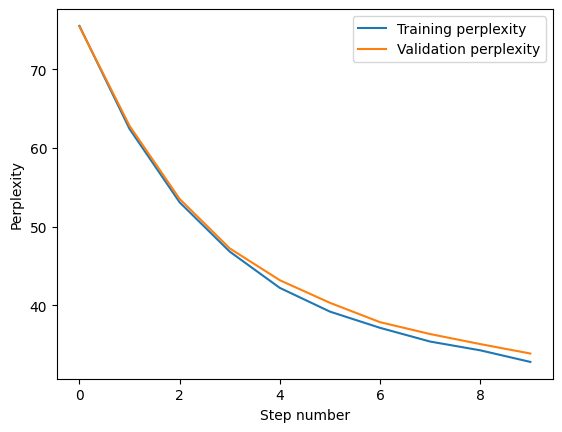

In [35]:
# plot training and validation perplexity
import matplotlib.pyplot as plt

plt.figure()

plt.plot(plot_steps, training, label = 'Training perplexity')
plt.plot(plot_steps, validation, label = 'Validation perplexity')

plt.ylabel('Perplexity')
plt.xlabel('Step number')
plt.legend()

In [36]:
# changing n_embd hyperparameter
n_embd = 32
n_head = 4 ## so head_size = 16
n_layer = 4

model = LanguageModel()
optimizer = torch.optim.Adam(model.parameters())

steps = 10
plot_steps = []
training = []
validation = []
for j in range(steps):
  X, Y = get_batch('train')
  logits, loss = model(X,Y)
  training_perplexity = torch.exp(estimate_loss()['train'])
  validation_perplexity = torch.exp(estimate_loss()['val'])
  print(f'Step number: {j}, Training perplexity: {training_perplexity} , Validation perplexity: {validation_perplexity}')
  loss.backward()
  optimizer.step()

  # for plots
  plot_steps.append(j)
  training.append(training_perplexity)
  validation.append(validation_perplexity)


Step number: 0, Training perplexity: 80.4468765258789 , Validation perplexity: 79.78134155273438
Step number: 1, Training perplexity: 74.38257598876953 , Validation perplexity: 74.46253204345703
Step number: 2, Training perplexity: 69.22868347167969 , Validation perplexity: 69.21369934082031
Step number: 3, Training perplexity: 64.4906997680664 , Validation perplexity: 64.78406524658203
Step number: 4, Training perplexity: 60.4715690612793 , Validation perplexity: 60.656654357910156
Step number: 5, Training perplexity: 57.181114196777344 , Validation perplexity: 57.44401550292969
Step number: 6, Training perplexity: 54.433406829833984 , Validation perplexity: 54.51971435546875
Step number: 7, Training perplexity: 51.839359283447266 , Validation perplexity: 51.9511604309082
Step number: 8, Training perplexity: 49.939064025878906 , Validation perplexity: 50.163883209228516
Step number: 9, Training perplexity: 47.90093994140625 , Validation perplexity: 48.2516975402832


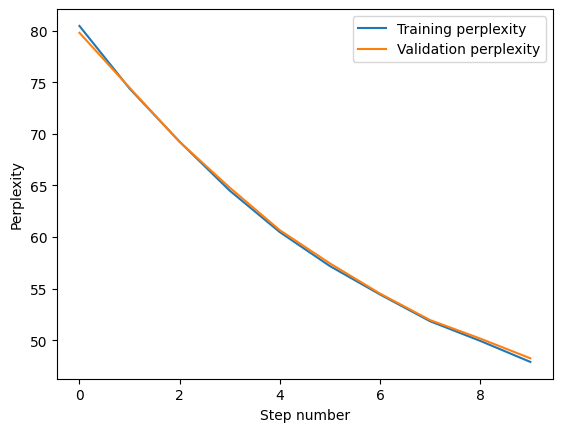

In [37]:
# plot training and validation perplexity
import matplotlib.pyplot as plt

plt.figure()

plt.plot(plot_steps, training, label = 'Training perplexity')
plt.plot(plot_steps, validation, label = 'Validation perplexity')

plt.ylabel('Perplexity')
plt.xlabel('Step number')
plt.legend()

In [38]:
# changing n_head hyperparameter
n_embd = 64
n_head = 2 ## so head_size = 16
n_layer = 4

model = LanguageModel()
optimizer = torch.optim.Adam(model.parameters())

steps = 10
plot_steps = []
training = []
validation = []
for j in range(steps):
  X, Y = get_batch('train')
  logits, loss = model(X,Y)
  training_perplexity = torch.exp(estimate_loss()['train'])
  validation_perplexity = torch.exp(estimate_loss()['val'])
  print(f'Step number: {j}, Training perplexity: {training_perplexity} , Validation perplexity: {validation_perplexity}')
  loss.backward()
  optimizer.step()

  # for plots
  plot_steps.append(j)
  training.append(training_perplexity)
  validation.append(validation_perplexity)

Step number: 0, Training perplexity: 74.21539306640625 , Validation perplexity: 74.84110260009766
Step number: 1, Training perplexity: 62.43045425415039 , Validation perplexity: 63.055442810058594
Step number: 2, Training perplexity: 54.532127380371094 , Validation perplexity: 55.2433967590332
Step number: 3, Training perplexity: 49.218231201171875 , Validation perplexity: 49.690982818603516
Step number: 4, Training perplexity: 45.54298782348633 , Validation perplexity: 46.10499954223633
Step number: 5, Training perplexity: 42.72282409667969 , Validation perplexity: 43.258358001708984
Step number: 6, Training perplexity: 40.636573791503906 , Validation perplexity: 41.1314582824707
Step number: 7, Training perplexity: 38.78392791748047 , Validation perplexity: 39.35673141479492
Step number: 8, Training perplexity: 37.20329666137695 , Validation perplexity: 37.88075637817383
Step number: 9, Training perplexity: 35.78566360473633 , Validation perplexity: 36.4022216796875


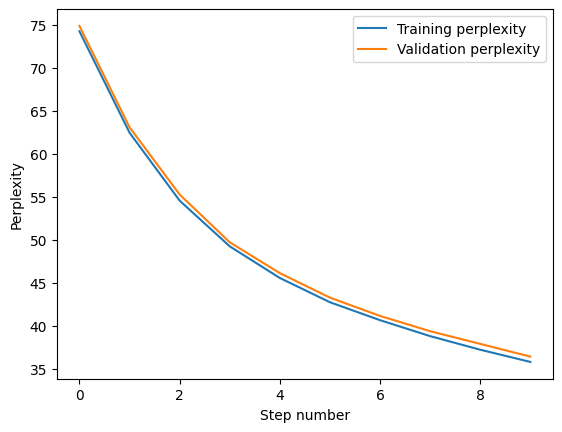

In [39]:
# plot training and validation perplexity
import matplotlib.pyplot as plt

plt.figure()

plt.plot(plot_steps, training, label = 'Training perplexity')
plt.plot(plot_steps, validation, label = 'Validation perplexity')

plt.ylabel('Perplexity')
plt.xlabel('Step number')
plt.legend()

In [40]:
# changing n_layer hyperparameter
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 6

model = LanguageModel()
optimizer = torch.optim.Adam(model.parameters())

steps = 10
plot_steps = []
training = []
validation = []
for j in range(steps):
  X, Y = get_batch('train')
  logits, loss = model(X,Y)
  training_perplexity = torch.exp(estimate_loss()['train'])
  validation_perplexity = torch.exp(estimate_loss()['val'])
  print(f'Step number: {j}, Training perplexity: {training_perplexity} , Validation perplexity: {validation_perplexity}')
  loss.backward()
  optimizer.step()

  # for plots
  plot_steps.append(j)
  training.append(training_perplexity)
  validation.append(validation_perplexity)

Step number: 0, Training perplexity: 84.34395599365234 , Validation perplexity: 83.97167205810547
Step number: 1, Training perplexity: 63.64958572387695 , Validation perplexity: 63.62351989746094
Step number: 2, Training perplexity: 51.92721176147461 , Validation perplexity: 52.530418395996094
Step number: 3, Training perplexity: 45.77064514160156 , Validation perplexity: 46.2584342956543
Step number: 4, Training perplexity: 41.99647903442383 , Validation perplexity: 42.75429153442383
Step number: 5, Training perplexity: 39.10746765136719 , Validation perplexity: 39.94626998901367
Step number: 6, Training perplexity: 37.30306625366211 , Validation perplexity: 37.76518630981445
Step number: 7, Training perplexity: 35.25825881958008 , Validation perplexity: 36.203125
Step number: 8, Training perplexity: 33.883819580078125 , Validation perplexity: 34.35995101928711
Step number: 9, Training perplexity: 32.11743927001953 , Validation perplexity: 33.22062683105469


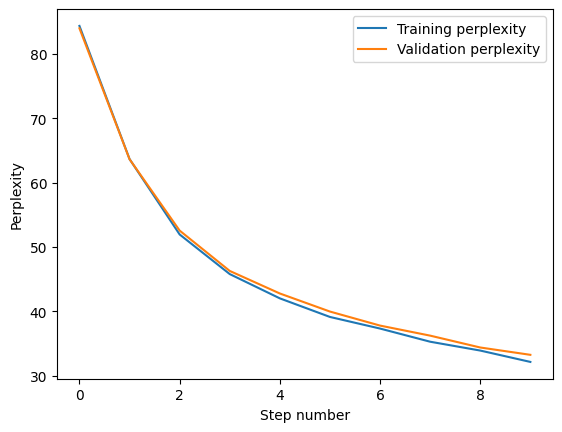

In [41]:
# plot training and validation perplexity
import matplotlib.pyplot as plt

plt.figure()

plt.plot(plot_steps, training, label = 'Training perplexity')
plt.plot(plot_steps, validation, label = 'Validation perplexity')

plt.ylabel('Perplexity')
plt.xlabel('Step number')
plt.legend()